# Predictor

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import time
import IPython
import IPython.display

In [3]:
from preprocess.data_generator import WindowSplitter
from nn.deepar import create_model
from preprocess.data_generator import DatasetGenerator

In [4]:
from dl.predictor import Predictor

In [5]:
HISTORICAL_CSV_FILE = "../data/data.csv"
RAW_CSV_FILE = '../data/preprocessed_data.csv'
MODEL_CHECKPOINT_PATH = "../checkpoints/deepar"

### Predictor

In [6]:
historical_df = pd.read_csv(HISTORICAL_CSV_FILE)
display(historical_df[:3])
len(historical_df)

,t,x,y,z,tx1,tx2,tx3,tx4,tx5,tx6,tx7,tx8,tx9
0,1.666162e+12,-627.51,649.33,108.78,-48.0,-77.0,-45.0,-42.0,-75.0,-57.0,-48.0,-41.0,-79.0
1,1.666162e+12,-627.51,649.33,101.66,-67.0,-72.0,-71.0,-42.0,-74.0,-59.0,-40.0,-41.0,-81.0
2,1.666162e+12,-616.07,648.94,93.54,-55.0,-60.0,-61.0,-50.0,-62.0,-69.0,-68.0,-56.0,-69.0


23448

In [15]:
class Predictor:
    def __init__(self, historical_df, checkpoint=MODEL_CHECKPOINT_PATH, max_window_size=300):
        self.historical_df = historical_df.drop(columns=['t'])
        self.epsilon = 1e-10
        self.mean = self.historical_df.mean()
        self.std = self.historical_df.std() + self.epsilon
        self.label_size = 3
        self.input_size = len(self.historical_df.columns[self.label_size:])
        self.columns = self.historical_df.columns
        self.measurement = {}
        self.init_measurement()
        self.max_window_size = max_window_size
        # model
        self.checkpoint = checkpoint
        self.model = None
        self.load_model()

    def summary(self):
        print('COLUMNS:', self.columns)
        print('MEAN:', list(self.mean))
        print('STD: ', list(self.std))
        print('LABEL SIZE: ', self.label_size)
        print('INPUT SIZE: ', self.input_size)
        print('RAW MEASUREMENT:', self.measurement)
        print('MAX WINDOW SIZE:', self.max_window_size)
        
    def init_measurement(self):
        for column in self.columns[self.label_size:]:
            self.measurement[column] = []
        
    def add_measurement(self, tx, rssi):
        if tx in self.measurement.keys():
            self.measurement[tx].append(rssi)
            if len(self.measurement[tx]) > self.max_window_size:
                self.measurement[tx] = self.measurement[tx][1:]
                
    def gen_input_seq(self):
        df = pd.DataFrame.from_dict(self.measurement)
        # normalize
        df = (df - self.mean[self.label_size:]) / self.std[self.label_size:]
        return tf.convert_to_tensor([df.to_numpy()])
    
    def load_model(self):
        self.model = create_model(dim_x=self.input_size, dim_z=self.label_size)
        # restore checkpoints if exist
        ckpt = tf.train.Checkpoint(model=self.model)
        ckpt_manager = tf.train.CheckpointManager(ckpt, self.checkpoint, max_to_keep=100)
        if ckpt_manager.latest_checkpoint:
            ckpt.restore(ckpt_manager.latest_checkpoint)
            print("Restoring checkpoint from {}".format(ckpt_manager.latest_checkpoint))

    def predict(self):
        inputs = self.gen_input_seq()
        mean, _ = self.model(inputs)
        return mean * self.std[:self.label_size] + self.mean[:self.label_size]
            
predictor = Predictor(historical_df=historical_df)
predictor.summary()

Restoring checkpoint from ../checkpoints/deepar\ckpt-30
COLUMNS: Index(['x', 'y', 'z', 'tx1', 'tx2', 'tx3', 'tx4', 'tx5', 'tx6', 'tx7', 'tx8',
       'tx9'],
      dtype='object')
MEAN: [-119.83717545206413, -257.4081171102013, 96.94185431593313, -68.088109860116, -189.01637666325487, -193.11007335380415, -196.9968440805186, -195.1737888092801, -192.27921357898327, -199.03428863868987, -193.91837256908906, -195.74965881951553]
STD:  [494.0797578874097, 601.0465169470805, 3.4196779383138405, 41.791069043961066, 93.48240489653595, 91.9112091027444, 89.43711940090556, 90.67251020902395, 92.21739891407908, 88.80841967195245, 90.5270596992318, 90.09811034941605]
LABEL SIZE:  3
INPUT SIZE:  9
RAW MEASUREMENT: {'tx1': [], 'tx2': [], 'tx3': [], 'tx4': [], 'tx5': [], 'tx6': [], 'tx7': [], 'tx8': [], 'tx9': []}
MAX WINDOW SIZE: 300


### Simulator

In [8]:
class World:
    def __init__(self, raw_df, predictor):
        self.raw_df = raw_df
        self.raw_df_size = len(self.raw_df)
        self.raw_df_iter = 0
        self.predictor = predictor
        self.label = []
        
    def get_measurement(self):
        if self.raw_df_iter > self.raw_df_size:
            return
        measurement = self.raw_df.iloc[[self.raw_df_iter]].values[0]
        self.raw_df_iter+=1
        tx = measurement[0]
        rssi = measurement[4]
        
        # add ground true
        last = None
        if len(self.label) > 0:
            last = self.label[-1]
        current = measurement[1:4]
        if (last != current).any():
            self.label.append(current)
            
        return tx.lower(), rssi
    
    def get_label(self):
        return np.array(self.label)
    
    def step(self):
        tx, rssi = self.get_measurement()
        predictor.add_measurement(tx, rssi)

In [26]:
raw_df = pd.read_csv(RAW_CSV_FILE)
# predictor = Predictor(on_predict=None, historical_csv_path=HISTORICAL_CSV_FILE, checkpoint=MODEL_CHECKPOINT_PATH, max_window_size=100)
predictor = Predictor(historical_df=historical_df)
world = World(raw_df=raw_df, predictor=predictor)
for i in range(9 * 500):
    world.step()

Restoring checkpoint from ../checkpoints/deepar\ckpt-30


In [27]:
for k, v in predictor.measurement.items():
    print(k, len(v))

tx1 300
tx2 300
tx3 300
tx4 300
tx5 300
tx6 300
tx7 300
tx8 300
tx9 300


In [34]:
result = predictor.predict()[0]
label = world.get_label()

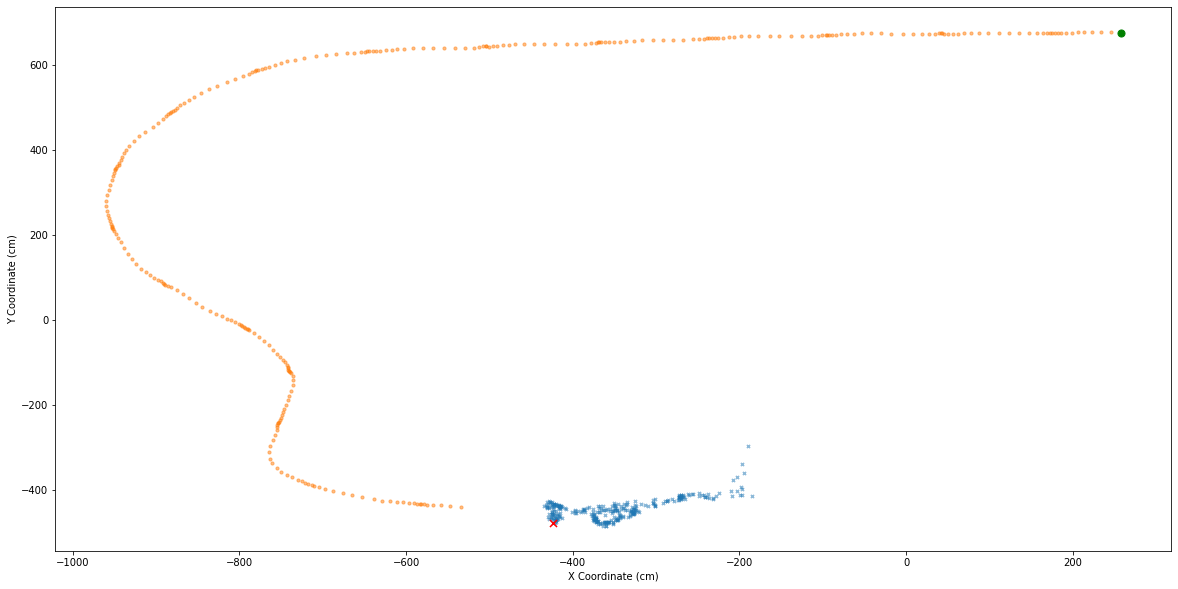

In [35]:
plt.figure(figsize=(20,10))
pred_len = len(result)
plt.scatter(result[:, 0].numpy(), result[:, 1].numpy(), s=10, marker='x', alpha=0.5)
plt.scatter(label[-pred_len:, 0], label[-pred_len:, 1], s=10, marker='o', alpha=0.5)
plt.scatter(result[-1, 0].numpy(), result[-1, 1].numpy(), s=50, marker='x', color='r', alpha=1)
plt.scatter(label[-1, 0], label[-1, 1], s=50, marker='o', color='g', alpha=1)
plt.xlabel('X Coordinate (cm)')
plt.ylabel('Y Coordinate (cm)')
plt.show()